# Preparação

Carregar as biliotecas e ler os caminhos de ENV.

In [1]:
# Import Libraries

import os
import pandas as pd
import joblib
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit



from sklearn import metrics
from sklearn import tree

import graphviz 
import re

In [2]:
# Set paths

data_set_path = os.environ['DATASET_PATH']
metrics_path = os.environ['METRICS_PATH']
model_path = os.environ['MODEL_PATH']
colname_path = os.environ['COLNAME_PATH']
imputer_path = os.environ['IMPUTER_PATH']


# Data Extraction

Carregar os dados do arquivo CSV.

In [3]:
# Load product data from CSV

product_data = pd.read_csv(data_set_path)

In [4]:
product_data

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37995,13230578,1756482,mochila personalizada galinha pintadinha,1,2,Mochila Galinha Pintadinha M,primaria 2019 1 aninho abdulzinho mochilas ani...,2016-09-17 10:49:39,18.790000,149.0,1,27,321,NaN,Lembrancinhas
37996,6736914,9301388,tag dia dos pais,1,32,30 TAGS DIA DOS PAIS 005,dia pais,2019-06-12 17:03:52,31.680000,7.0,1,1,43,NaN,Papel e Cia
37997,11017911,8732362,kit bolsa maternidade,5,31,Kit bolsa bebê maternidade personalizada,paula carvalho bebe,2018-08-24 11:43:00,543.170000,3006.0,1,4,515,18.0,Bebê
37998,6807331,1869417,festa 15 anos,1,8,Chaveiro Almofada 15 anos,yasmin centro mesa compras 15 anos 2020 lembra...,2017-10-21 18:49:56,10.720000,18.0,1,53,2456,138.0,Lembrancinhas


Verificar quantas categorias existem, para entender melhor o problema de classificação.

In [5]:
product_data.category.value_counts()

Lembrancinhas         17524
Decoração              8723
Bebê                   6930
Papel e Cia            2750
Outros                 1133
Bijuterias e Jóias      940
Name: category, dtype: int64

# Data Formatting

Remover a coluna *product_id*, porque ela é provavelmente um identificador aletatório que não contém nenhuma informação relevante.


In [6]:
product_data_prepared = product_data.drop(columns=['product_id'])

product_data_prepared.columns

Index(['seller_id', 'query', 'search_page', 'position', 'title',
       'concatenated_tags', 'creation_date', 'price', 'weight',
       'express_delivery', 'minimum_quantity', 'view_counts', 'order_counts',
       'category'],
      dtype='object')

Transformar a coluna *creation_date* em unix timestamp porque o classificador consegue trabalhar apenas com campos numéricos.

In [7]:

product_data_prepared['creation_date'] = pd.to_datetime(product_data_prepared['creation_date'], format='%Y-%m-%d %H:%M:%S').astype(int) / 10**9

product_data_prepared['creation_date']


0        1.447530e+09
1        1.522875e+09
2        1.539464e+09
3        1.488202e+09
4        1.494336e+09
             ...     
37995    1.474109e+09
37996    1.560359e+09
37997    1.535111e+09
37998    1.508612e+09
37999    1.509151e+09
Name: creation_date, Length: 38000, dtype: float64


Fazer um one-hot-encoding do *seller_id* para o classificador consegue interpretar melhor o conteúdo do campo. Cada vendedor é independente portanto cada vendedor precisa sua coluna. Não há uma corelação entre os vendedores e seus id's, p.ex. vendedor com id 1500 é 2 vezes mais importante do que o vendedor com id 3000.

Como muitos vendedores tem poucos produtos listados, focamos apenas nos 100 vendedores que tem mais produtos listados.


In [8]:

top_100_sellers = sorted([x for x in product_data.seller_id.value_counts().head(100).index])

# Build data frame with one-hot encoded seller_id
enc = OneHotEncoder(categories=[top_100_sellers],handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(product_data_prepared[['seller_id']]).toarray())
enc_df.columns = ['seller_id_'+str(col) for col in top_100_sellers]

# Replace seller_id column with one-hot-encoded data frame
product_data_prepared = product_data_prepared.drop(columns=['seller_id'])
product_data_prepared = product_data_prepared.join(enc_df)


product_data_prepared



,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,...,seller_id_9209348,seller_id_9264224,seller_id_9363103,seller_id_9377206,seller_id_9429411,seller_id_9660523,seller_id_9690400,seller_id_9759698,seller_id_9953960,seller_id_10087017
0,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,1.447530e+09,171.890000,1200.0,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,1.522875e+09,77.670000,8.0,1,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,1.539464e+09,73.920006,2709.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,1.488202e+09,118.770004,0.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,1.494336e+09,191.810000,507.0,1,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37995,mochila personalizada galinha pintadinha,1,2,Mochila Galinha Pintadinha M,primaria 2019 1 aninho abdulzinho mochilas ani...,1.474109e+09,18.790000,149.0,1,27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37996,tag dia dos pais,1,32,30 TAGS DIA DOS PAIS 005,dia pais,1.560359e+09,31.680000,7.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37997,kit bolsa maternidade,5,31,Kit bolsa bebê maternidade personalizada,paula carvalho bebe,1.535111e+09,543.170000,3006.0,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37998,festa 15 anos,1,8,Chaveiro Almofada 15 anos,yasmin centro mesa compras 15 anos 2020 lembra...,1.508612e+09,10.720000,18.0,1,53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Transformar as colunas de texto (query, title e concatenated_tags) em contagens de palavaras. Ou seja, se houver "box banheiro adesivo" na coluna "title", haverá colunas com os nomes *title_box*, *title_banheiro*, *title_adesivo* cujo valores para o respective dataset são "1".

In [9]:
# Transform query, title and concatenated_tags field

# Create a transformation function
def generate_word_count_frame(column):
    # Limit the verctorizer to the 1.000 most popular words (for memory & speed reasons)
    cv = CountVectorizer(max_features=1000)

    column = column.fillna('')
    tf = cv.fit_transform(column)

    word_count_frame = pd.DataFrame(tf.toarray(), columns=cv.get_feature_names())
    word_count_frame.columns = [column.name+'_'+str(col) for col in word_count_frame.columns]
    
    return word_count_frame    


In [10]:
    
# Run transformation on each relevant column

word_counts = {}
for column in ['query','title','concatenated_tags']:
    word_counts[column] = generate_word_count_frame(product_data[column])


Testar o resultado da transformação no caso da coluna *title*

In [11]:
word_counts["title"]

,title_00,title_01,title_02,title_03,title_05,title_10,title_100,title_10mm,title_12,title_15,...,title_você,title_voil,title_vovó,title_vovô,title_xícara,title_água,title_álbum,title_álcool,title_árvore,title_ímã
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37998,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Substituir as colunas *query*, *title* e *concatenated_tags* pelas colunas de 'word_count'.


In [12]:
# Drop query, title and concatenated_tags columns & append word_count data frames

product_data_prepared = product_data_prepared.drop(columns=['query'])
product_data_prepared = product_data_prepared.join(word_counts['query'])

product_data_prepared = product_data_prepared.drop(columns=['title'])
product_data_prepared = product_data_prepared.join(word_counts['title'])

product_data_prepared = product_data_prepared.drop(columns=['concatenated_tags'])
product_data_prepared = product_data_prepared.join(word_counts['concatenated_tags'])

product_data_prepared


,search_page,position,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category,...,concatenated_tags_vinicius,concatenated_tags_vinil,concatenated_tags_vintage,concatenated_tags_visita,concatenated_tags_vitor,concatenated_tags_volta,concatenated_tags_vovo,concatenated_tags_wedding,concatenated_tags_xicaras,concatenated_tags_yasmin
0,2,6,1.447530e+09,171.890000,1200.0,1,4,244,NaN,Decoração,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1.522875e+09,77.670000,8.0,1,5,124,NaN,Papel e Cia,...,0,0,0,1,0,0,0,0,0,0
2,1,38,1.539464e+09,73.920006,2709.0,1,1,59,NaN,Outros,...,0,0,0,0,0,0,0,0,0,0
3,1,6,1.488202e+09,118.770004,0.0,1,1,180,1.0,Bebê,...,0,0,0,0,0,0,0,0,0,0
4,3,38,1.494336e+09,191.810000,507.0,1,6,34,NaN,Decoração,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37995,1,2,1.474109e+09,18.790000,149.0,1,27,321,NaN,Lembrancinhas,...,0,0,0,0,0,0,0,0,0,0
37996,1,32,1.560359e+09,31.680000,7.0,1,1,43,NaN,Papel e Cia,...,0,0,0,0,0,0,0,0,0,0
37997,5,31,1.535111e+09,543.170000,3006.0,1,4,515,18.0,Bebê,...,0,0,0,0,0,0,0,0,0,0
37998,1,8,1.508612e+09,10.720000,18.0,1,53,2456,138.0,Lembrancinhas,...,0,0,0,0,0,0,0,0,0,1


Split data em X (input) and Y (output).

In [23]:

product_data_prepared_X = product_data_prepared.drop(columns='category')
product_data_prepared_Y = product_data_prepared['category']


Ordenar as colunas para poder substituir na criação do API mais tarde.

In [24]:
# Sort dataframe by column name

product_data_prepared_X = product_data_prepared_X.sort_index(axis=1)

product_data_prepared_X


,concatenated_tags_02,concatenated_tags_10,concatenated_tags_100,concatenated_tags_12,concatenated_tags_15,concatenated_tags_15anos,concatenated_tags_18,concatenated_tags_18k,concatenated_tags_1a,concatenated_tags_2018,...,title_vovó,title_vovô,title_xícara,title_água,title_álbum,title_álcool,title_árvore,title_ímã,view_counts,weight
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,244,1200.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,124,8.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,59,2709.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,180,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,34,507.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,321,149.0
37996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,43,7.0
37997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,515,3006.0
37998,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2456,18.0


Transformar valores de NaN em medias usando o SimpleImputer do sklearn.

In [25]:
    
product_data_prepared_X['weight'].isna().value_counts()


False    37942
True        58
Name: weight, dtype: int64

In [27]:


imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
idf = pd.DataFrame(imp_mean.fit_transform(product_data_prepared_X))
idf.columns = product_data_prepared_X.columns
idf.index = product_data_prepared_X.index
product_data_prepared_X = idf


In [28]:

product_data_prepared_X['weight'].isna().value_counts()


False    38000
Name: weight, dtype: int64

# Modeling

Separar conjunto de dados de treinamento e validação.

In [29]:
# Prepare data and folder

data_X = product_data_prepared_X
data_Y = product_data_prepared_Y

X_train, X_test, Y_train, Y_test = train_test_split( data_X, data_Y, test_size=0.1, random_state=3884)


Criar um classificador de arvore e treina o modelo. Para ter um modelo mais simples que pode ser visualizado, o número maximo de folhas da árvore será limitada a 48 folhas.

In [30]:

clf = DecisionTreeClassifier(max_leaf_nodes = 48,random_state = 2232)
clf.fit(X_train,Y_train)


DecisionTreeClassifier(max_leaf_nodes=48, random_state=2232)

# Model Validation

Medir metricas do modelo e mostra-las.

In [31]:

Y_pred = clf.predict(X_test)

classification_report = metrics.classification_report(Y_test,Y_pred)

print(classification_report)


                    precision    recall  f1-score   support

              Bebê       0.90      0.63      0.74       724
Bijuterias e Jóias       1.00      0.55      0.71        91
         Decoração       0.63      0.84      0.72       862
     Lembrancinhas       0.78      0.90      0.84      1732
            Outros       1.00      0.02      0.03       123
       Papel e Cia       0.77      0.31      0.44       268

          accuracy                           0.76      3800
         macro avg       0.85      0.54      0.58      3800
      weighted avg       0.78      0.76      0.74      3800



O classificador funciona relativamente bem para as categórias de *Bebê*, *Biijuterias & Jóias* e *Decoração & Lembracinhas*. Nesses casos mais do que a metade de itens foram classificados corretamente, tanto em respeito da precisão (mais do que a metade dos itens classificado como uma detereminada categoria realmente são dessa categoria) quanto em respeito do recall (mais do que a metade de itens de uma categoria foram classficados corretamente).

No caso das categórias de *Outros* e *Papel & Cia* apenas a precisão é boa, ou seja quanto um item foi classificado a probabilidade que a classificação é correta é alta. Porém poucos itens dessas categórias foram classificads corretamente (baixo recall).


Escreve o reporte para 'metrics_path'.

In [32]:

f = open(metrics_path, "w")
f.write(classification_report)
f.close()


# Model exportation & visualization

Exporta o modelo para 'model_path'.

In [33]:

joblib.dump(clf, model_path, compress=9)


['/usr/src/data/model.pkl']

Exporta a lista de nomes de colunas.

In [34]:
joblib.dump(data_X.columns, colname_path, compress=9)

['/usr/src/data/colname.joblib']

Salvar o simple Imputer.

In [35]:
joblib.dump(imp_mean, imputer_path, compress=9)

['/usr/src/data/imputer.joblib']

Visualizar a arvore usando o pacote de graphviz.

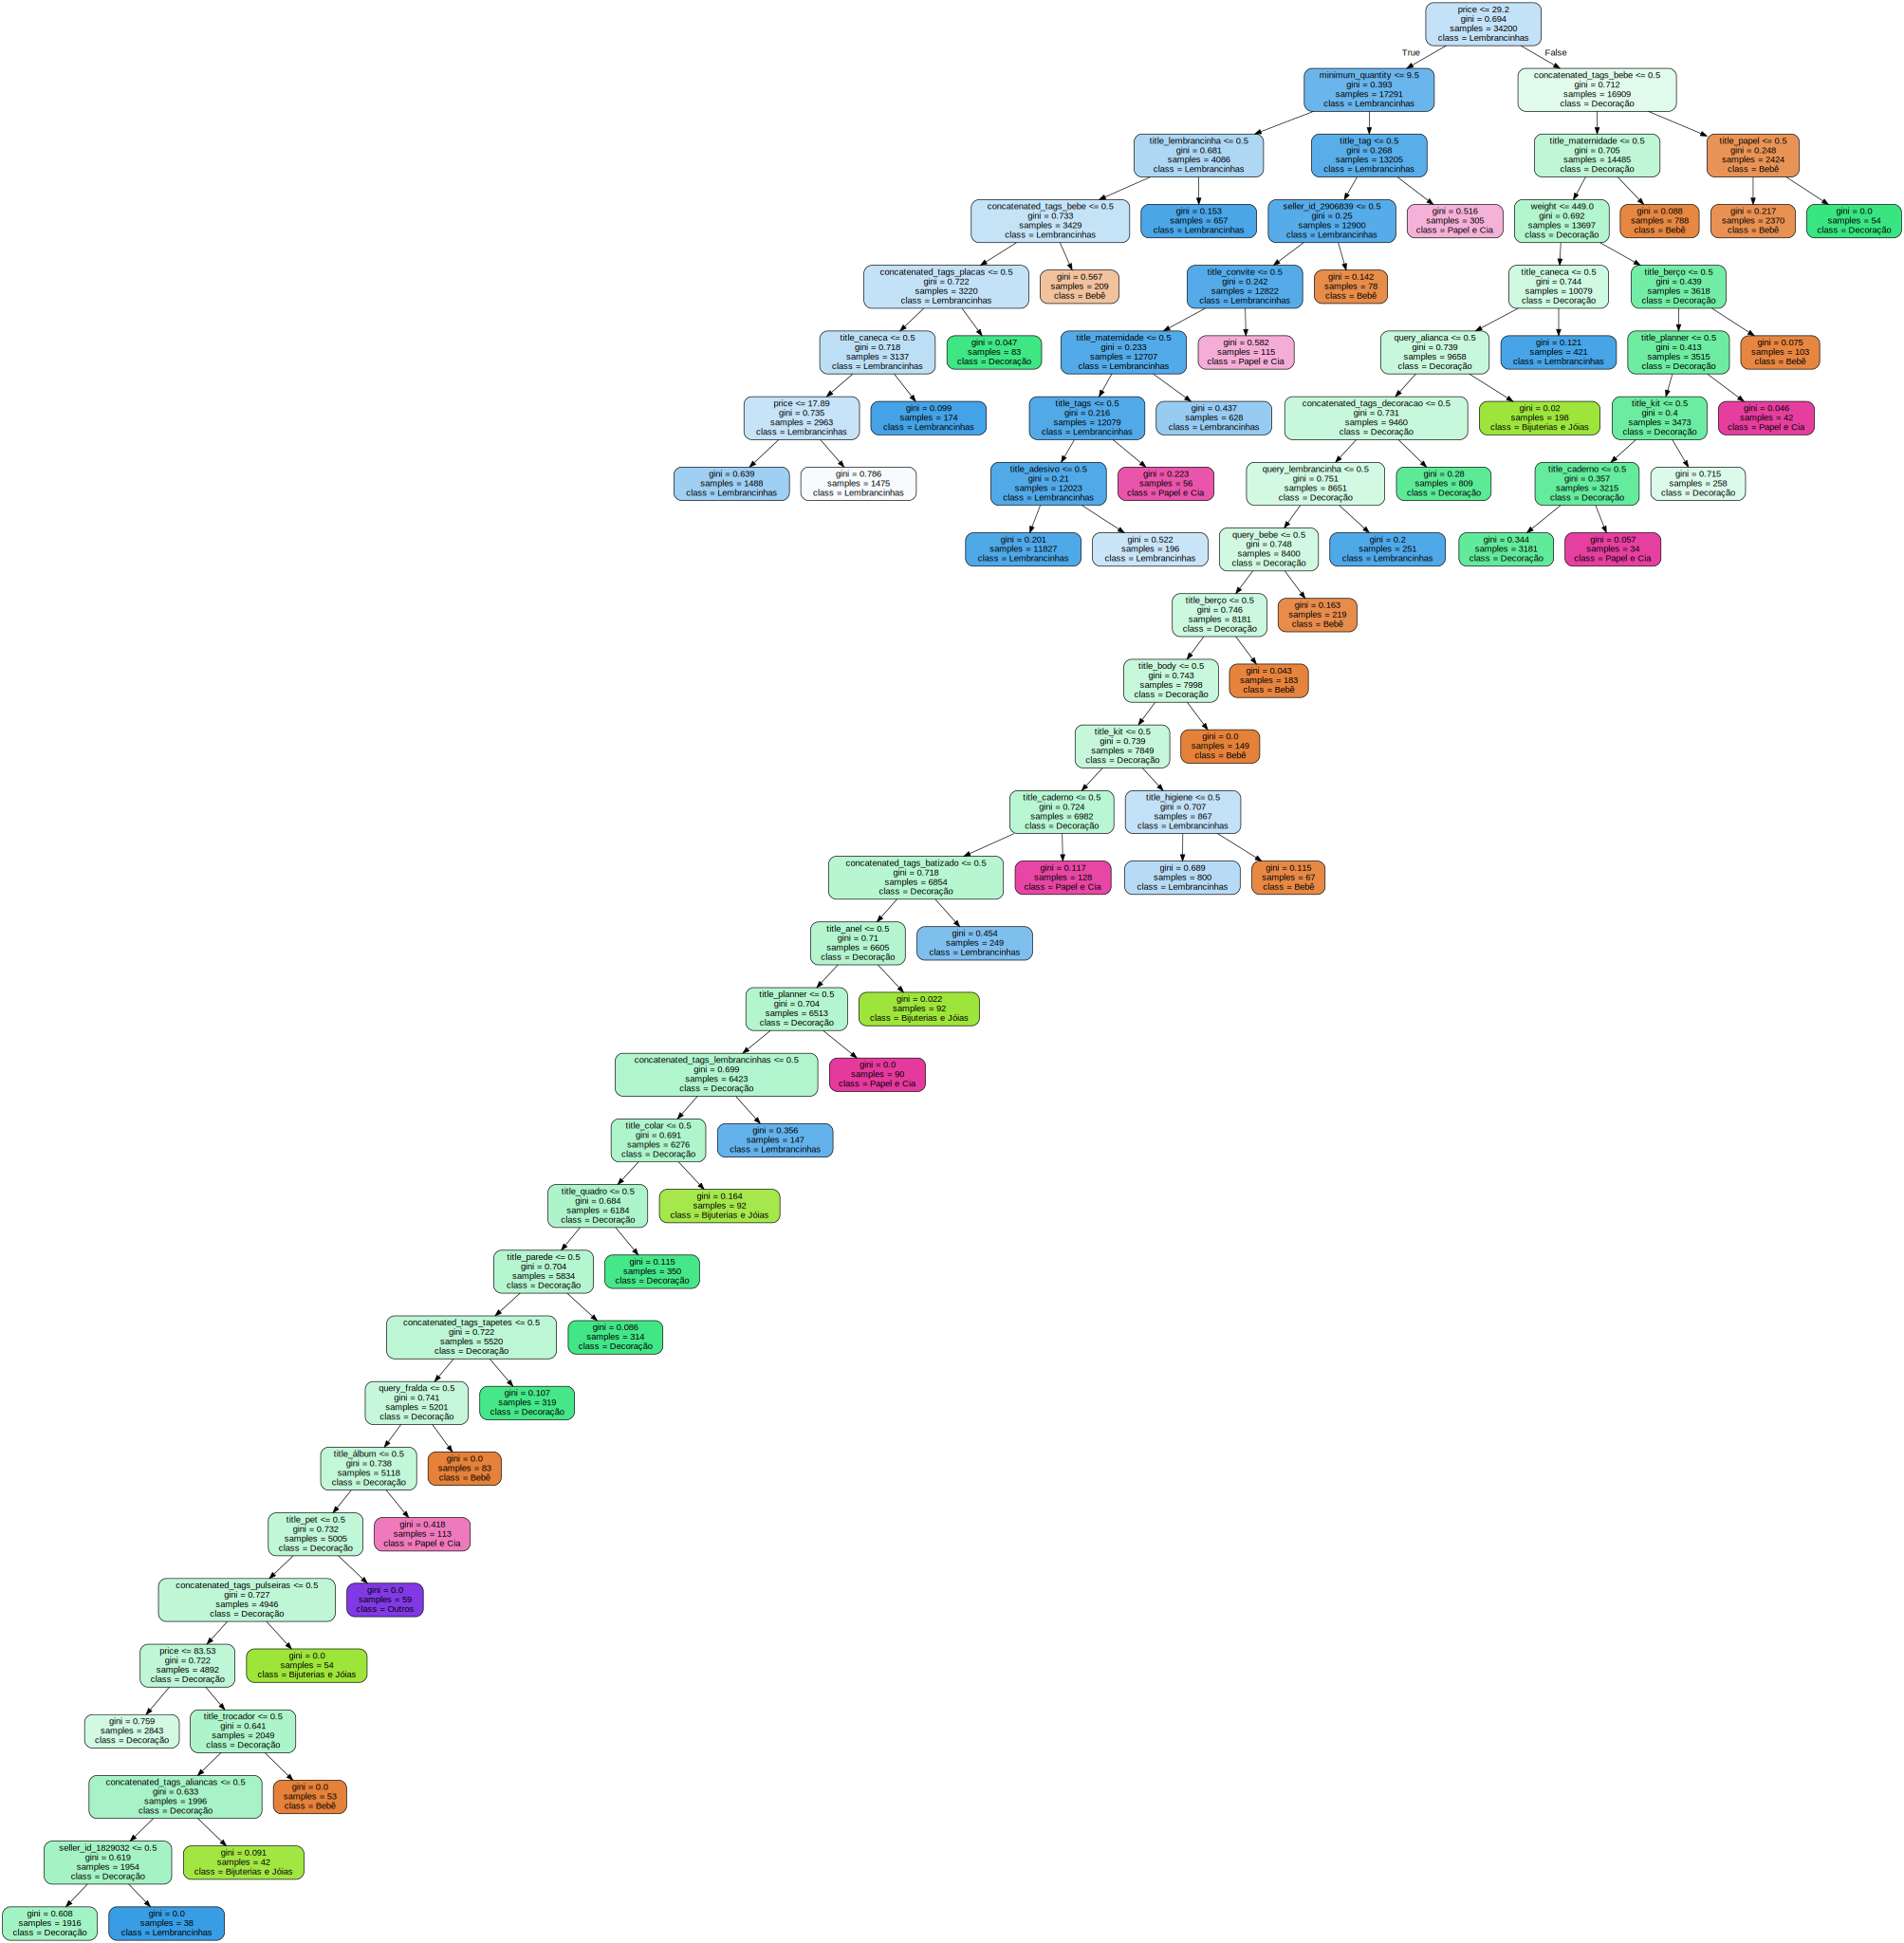

In [36]:
# Print decsion tree

dot_data = tree.export_graphviz(clf, \
                                out_file=None, \
                                feature_names=X_train.columns, \
                                filled=True, \
                                rounded=True, \
                                class_names=clf.classes_)

# Remove value fields since they blow up the nodes and make the tree harder to read
dot_data = re.sub(r'\\nvalue = \[[\d\,\s\\n]+\]', '', dot_data)

graph = graphviz.Source(dot_data) 

graph


Fato interessante da arvore de classificação é que o primeiro críteiro é o preço (quando o preço for menor do que 29,2 o produto tem uma alta chance de ser da categória *Lembracinhas*). 